In [1]:
import os
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

In [2]:
import cudf as gd
import pandas as pd
import numpy as np
import math
import xgboost as xgb
import seaborn as sns
from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from termcolor import colored
from cudf_workaround import cudf_groupby_aggs
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")
sns.set()
print('cudf version',gd.__version__)

cudf version 0.7.2+0.g3ebd286.dirty


**This notebook demos the 8th place solution (8/1094) of Rapids.ai for the __[PLAsTiCC Astronomical Classification](https://www.kaggle.com/c/PLAsTiCC-2018/leaderboard)__. The demo shows up to 140x speedup for ETL and 25x end-to-end speedup over the CPU solution. More details can be found at our __[blog](https://medium.com/rapids-ai/make-sense-of-the-universe-with-rapids-ai-d105b0e5ec95)__** 

## Table of contents
[1. Global variables](#global)<br>
[2. Functions](#func)<br>
[3. ETL & Visualizations](#etl)<br>
[4. Model training](#train)<br>
[5. Conclusions](#conclusions)

<a id="global"></a>
## 1. Global variables 

**Original data download and description __[link](https://www.kaggle.com/c/PLAsTiCC-2018/data)__**.

In [3]:
PATH = '../data'
#PATH = '/raid/data/ml/lsst/input'
#PATH = '../lsst/input'

**Tested on V100 with 32 GB GPU memory. If memory capacity is smaller, the input data will be sampled accordingly.**

In [4]:
GPU_MEMORY = 32 # GB. 
#GPU_MEMORY = 16 # GB. Both 32 and 16 GB have been tested

In [5]:
TEST_ROWS = 453653104 # number of rows in test data
# no skip if your gpu has 32 GB memory
# otherwise, skip rows porportionally
OVERHEAD = 1.2 # cudf 0.7 introduces 20% memory overhead
SKIP_ROWS = int((1 - GPU_MEMORY/(32.0*OVERHEAD))*TEST_ROWS) 
GPU_RUN_TIME = {}
CPU_RUN_TIME = {}

In [6]:
GPU_id = 0
os.environ['CUDA_VISIBLE_DEVICES'] = str(GPU_id)

<a id="func"></a>
## 2. Functions

In [7]:
def scatter(x,y,values,xlabel='x',ylabel='y',title=None):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    colors = np.array([colors[i] for i in values])
    ps = []
    bs = []
    bands = ['passband_%s'%i for i in ['u', 'g', 'r', 'i', 'z','y']]
    for i in sorted(np.unique(values)):
        mask = values==i
        if len(x[mask]):
            p = plt.scatter(x[mask],y[mask],c=colors[mask])
            ps.append(p)
            bs.append(bands[i])
    plt.legend(ps,bs,scatterpoints=1)
    if title is not None:
        plt.title(title)
    
    plt.xlim([np.min(x)-10,np.min(x)+1500])
    plt.ylabel('y: %s'%ylabel)
    plt.xlabel('x: %s'%xlabel)

In [8]:
def multi_weighted_logloss(y_true, y_preds, classes, class_weights):
    """
    refactor from
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    y_ohe = pd.get_dummies(y_true)
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    y_p_log = np.log(y_p)
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    class_arr = np.array([class_weights[k] for k in sorted(class_weights.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

def xgb_multi_weighted_logloss(y_predicted, y_true, classes, class_weights):
    loss = multi_weighted_logloss(y_true.get_label(), y_predicted, 
                                  classes, class_weights)
    return 'wloss', loss

### CPU ETL functions 

In [9]:
def ravel_column_names(cols):
    d0 = cols.get_level_values(0)
    d1 = cols.get_level_values(1)
    return ["%s_%s"%(i,j) for i,j in zip(d0,d1)]
    
def etl_cpu(df,df_meta):
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    aggs = {
        'passband': ['mean'], 
        'flux': ['min', 'max', 'mean'],
        'flux_err': ['min', 'max', 'mean'],
        'detected': ['mean'],
        'mjd':['max','min'],
        'flux_ratio_sq':['sum'],
        'flux_by_flux_ratio_sq':['sum'],
    }
    agg_df = df.groupby('object_id').agg(aggs)
    agg_df.columns = ravel_column_names(agg_df.columns)
    
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    agg_df['flux_dif2'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_sum'] / agg_df['flux_ratio_sq_sum']
    agg_df['flux_dif3'] = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']
    
    agg_df['mjd_diff'] = agg_df['mjd_max'] - agg_df['mjd_min']
    agg_df = agg_df.drop(['mjd_max','mjd_min'],axis=1)
    
    agg_df = agg_df.reset_index()
    df_meta = df_meta.drop(['ra','decl','gal_l','gal_b'],axis=1)
    df_meta = df_meta.merge(agg_df,on='object_id',how='left')
    return df_meta

### GPU ETL functions 

In [10]:
# To save GPU memory, we drop the column as soon as it is done with groupby
# this hits performance a little but avoids GPU OOM.
def groupby_aggs(df,aggs,col):
    res = None
    for i,j in aggs.items():
        for k in j:
            #print(i,k)
            tmp = df.groupby(col,as_index=False).agg({i:[k]})
            if res is None:
                res = tmp
            else:
                res = res.merge(tmp,on=[col],how='left')
        df.drop_column(i)
    return res

def etl_gpu(df,df_meta):
    aggs = {
        'passband': ['mean'], 
        'detected': ['mean'],
        'mjd':['max','min'],
    }
    agg_df = groupby_aggs(df,aggs,'object_id')
    # at this step, columns ['passband','detected','mjd'] are deleted 
    
    df['flux_ratio_sq'] = df['flux'] / df['flux_err']
    df['flux_ratio_sq'] = df['flux_ratio_sq'].applymap(lambda x: math.pow(x,2))
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
    
    aggs2 = {
        'flux_ratio_sq':['sum'],
        'flux_by_flux_ratio_sq':['sum'],
        'flux': ['min', 'max', 'mean'],
        'flux_err': ['min', 'max', 'mean'],
    }
    agg_df2 = groupby_aggs(df,aggs2,'object_id')
    agg_df = agg_df.merge(agg_df2,on=['object_id'],how='left')
    del agg_df2

    agg_df['flux_diff'] = agg_df['max_flux'] - agg_df['min_flux']
    agg_df['flux_dif2'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['mean_flux']
    agg_df['flux_w_mean'] = agg_df['sum_flux_by_flux_ratio_sq'] / agg_df['sum_flux_ratio_sq']
    agg_df['flux_dif3'] = (agg_df['max_flux'] - agg_df['min_flux']) / agg_df['flux_w_mean']
    
    agg_df['mjd_diff'] = agg_df['max_mjd'] - agg_df['min_mjd']
    agg_df.drop_column('max_mjd')
    agg_df.drop_column('min_mjd')
    
    for col in ['ra','decl','gal_l','gal_b']:
        df_meta.drop_column(col)
    
    df_meta = df_meta.merge(agg_df,on=['object_id'],how='left')
    return df_meta

<a id="etl"></a>
## 3. ETL & Visualizations

### Load data for ETL part 1
**GPU load data**

In [11]:
%%time
start = time.time()
step = 'load data part1'
ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']

train_gd = gd.read_csv('%s/training_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1)
test_gd = gd.read_csv('%s/test_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1+SKIP_ROWS) # skip the header
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 16.2 s, sys: 6.67 s, total: 22.9 s
Wall time: 22.9 s


**CPU load data**

In [12]:
%%time
start = time.time()
train = pd.read_csv('%s/training_set.csv'%PATH)
test = pd.read_csv('%s/test_set.csv'%PATH,skiprows=range(1,1+SKIP_ROWS))
CPU_RUN_TIME[step] = time.time() - start

CPU times: user 4min 7s, sys: 1min 17s, total: 5min 25s
Wall time: 3min 55s


In [13]:
speedup = CPU_RUN_TIME[step]/GPU_RUN_TIME[step]
line = "we achieve %.3f speedup for %s."%(speedup,step)
print(colored(line,'green'))

we achieve 10.279 speedup for load data part1.


### Visualizations

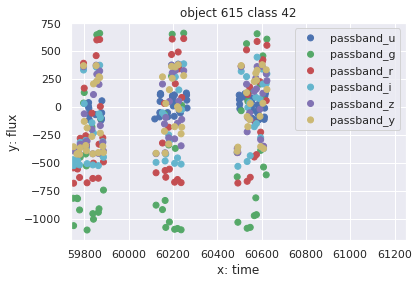

In [14]:
oid = 615
mask = train.object_id== oid
scatter(train.loc[mask,'mjd'].values,
                train.loc[mask,'flux'].values,
                values=train.loc[mask,'passband'].values,
                xlabel='time',ylabel='flux',title='object %d class 42'%oid)

### ETL part 1 with 100x  speedup

In [15]:
%%time
# to save memory, we need to move dataframe to cpu and only keep the columns we need
test_gd = test_gd[['object_id','flux']]
train_gd = train_gd[['object_id','flux']]

CPU times: user 8 ms, sys: 12 ms, total: 20 ms
Wall time: 18.8 ms


In [16]:
%%time
# GPU
step = 'ETL part1'
start = time.time()
aggs = {'flux':['skew']}
test_gd = cudf_groupby_aggs(test_gd,group_id_col='object_id',aggs=aggs)
train_gd = cudf_groupby_aggs(train_gd,group_id_col='object_id',aggs=aggs)
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 11.1 s, sys: 1.54 s, total: 12.7 s
Wall time: 5.11 s


In [17]:
%%time
# CPU
start = time.time()
test = test.groupby('object_id').agg(aggs)
train = train.groupby('object_id').agg(aggs)
CPU_RUN_TIME[step] = time.time() - start

CPU times: user 12min 20s, sys: 39.6 s, total: 12min 59s
Wall time: 12min 44s


In [18]:
speedup = CPU_RUN_TIME[step]/GPU_RUN_TIME[step]
line = "we achieve %.3f speedup for %s."%(speedup,step)
print(colored(line,'green'))

we achieve 149.524 speedup for ETL part1.


In [19]:
%%time
test_gd = test_gd.sort_values(by='object_id')
train_gd = train_gd.sort_values(by='object_id')

CPU times: user 76 ms, sys: 40 ms, total: 116 ms
Wall time: 119 ms


In [20]:
%%time
test.columns = ['skew_flux']
test = test.reset_index()
test = test.sort_values(by='object_id')
train.columns = ['skew_flux']
train = train.reset_index()
train = train.sort_values(by='object_id')

CPU times: user 6.83 s, sys: 512 ms, total: 7.34 s
Wall time: 205 ms


**Evaluation of correctness of ETL**

In [21]:
print(len(test),len(test_gd))

2953948 2953948


In [22]:
# RMSE: Root mean square error
def rmse(a,b):
    return np.mean((a-b)**2)**0.5
print('test')
for col in test.columns:
    if col in test_gd.columns:
        print("%s, rmse %.6f"%(col,rmse(test[col].values,test_gd[col].to_pandas().values)))
print('train')
for col in train.columns:
    if col in train_gd.columns:
        print("%s, rmse %.6f"%(col,rmse(train[col].values,train_gd[col].to_pandas().values)))

test
object_id, rmse 0.000000
skew_flux, rmse 0.000002
train
object_id, rmse 0.000000
skew_flux, rmse 0.000006


In [23]:
# Rename the variables
test_flux_skew_gd = test_gd
test_flux_skew = test
train_flux_skew_gd = train_gd
train_flux_skew = train
print(len(test_gd),len(test))

2953948 2953948


### Load data for the ETL part 2 with 11x speedup

In [24]:
%%time
# read data on gpu
step = 'load data part2'
start = time.time()
ts_cols = ['object_id', 'mjd', 'passband', 'flux', 'flux_err', 'detected']
ts_dtypes = ['int32', 'float32', 'int32', 'float32','float32','int32']

test_gd = gd.read_csv('%s/test_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1+SKIP_ROWS) # skip the header
train_gd = gd.read_csv('%s/training_set.csv'%PATH,
            names=ts_cols,dtype=ts_dtypes,skiprows=1)

cols = ['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf',
       'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 
       'distmod','mwebv', 'target']
dtypes = ['int32']+['float32']*4+['int32']+['float32']*5+['int32']

train_meta_gd = gd.read_csv('%s/training_set_metadata.csv'%PATH,
            names=cols,dtype=dtypes,skiprows=1)
del cols[-1],dtypes[-1]
test_meta_gd = gd.read_csv('%s/test_set_metadata.csv'%PATH,
            names=cols,dtype=dtypes,skiprows=1)
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 22.2 s, sys: 8.02 s, total: 30.2 s
Wall time: 23 s


In [25]:
%%time
# read data on cpu
start = time.time()
test = pd.read_csv('%s/test_set.csv'%PATH,skiprows=range(1,1+SKIP_ROWS))
test_meta = pd.read_csv('%s/test_set_metadata.csv'%PATH)

train = pd.read_csv('%s/training_set.csv'%PATH)
train_meta = pd.read_csv('%s/training_set_metadata.csv'%PATH)
CPU_RUN_TIME[step] = time.time() - start

CPU times: user 3min 58s, sys: 1min 1s, total: 5min
Wall time: 4min


In [26]:
speedup = CPU_RUN_TIME[step]/GPU_RUN_TIME[step]
line = "we achieve %.3f speedup for %s."%(speedup,step)
print(colored(line,'green'))

we achieve 10.428 speedup for load data part2.


### ETL part2 with 9x ~ 12x speedup 

In [27]:
%%time
# GPU
start = time.time()
step = 'ETL part2'
train_final_gd = etl_gpu(train_gd,train_meta_gd)
train_final_gd = train_final_gd.merge(train_flux_skew_gd,on=['object_id'],how='left')
test_final_gd = etl_gpu(test_gd,test_meta_gd)
del test_gd,test_meta_gd
test_final_gd = test_final_gd.merge(test_flux_skew_gd,on=['object_id'],how='left')
GPU_RUN_TIME[step] = time.time() - start

CPU times: user 8.01 s, sys: 1.85 s, total: 9.86 s
Wall time: 6.76 s


In [28]:
%%time
#CPU
start = time.time()
train_final = etl_cpu(train,train_meta)
train_final = train_final.merge(train_flux_skew,on=['object_id'],how='left')
test_final = etl_cpu(test,test_meta)
test_final = test_final.merge(test_flux_skew,on=['object_id'],how='left')
CPU_RUN_TIME[step] = time.time() - start

CPU times: user 4min 26s, sys: 2min 10s, total: 6min 37s
Wall time: 2min 19s


In [29]:
speedup = CPU_RUN_TIME[step]/GPU_RUN_TIME[step]
line = "we achieve %.3f speedup for %s."%(speedup,step)
print(colored(line,'green'))

we achieve 20.610 speedup for ETL part2.


<a id="train"></a>
## 4. Model training

### train and validation with 5x speedup

In [30]:
# CPU
X = train_final.drop(['object_id','target'],axis=1).values
y = train_final['target']
Xt = test_final.drop(['object_id'],axis=1).values
assert X.shape[1] == Xt.shape[1]
classes = sorted(y.unique())    
# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weights = {c: 1 for c in classes}
class_weights.update({c:2 for c in [64, 15]})

lbl = LabelEncoder()
y = lbl.fit_transform(y)
print(lbl.classes_)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y, random_state=126)

[ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]


In [31]:
cpu_params = {
            'objective': 'multi:softprob', 
            'tree_method': 'hist', 
            'nthread': 16, 
            'num_class':14,
            'max_depth': 7, 
            'silent':1,
            'subsample':0.7,
            'colsample_bytree': 0.7,}

In [32]:
func_loss = partial(xgb_multi_weighted_logloss, 
                        classes=classes, 
                        class_weights=class_weights)

In [33]:
%%time
start = time.time()
step = 'training'
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_test, label=y_test)
dtest = xgb.DMatrix(data=Xt)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
clf = xgb.train(cpu_params, dtrain=dtrain,
                num_boost_round=60,evals=watchlist,
                feval=func_loss,early_stopping_rounds=10,
                verbose_eval=1000)
yp = clf.predict(dvalid)
cpu_loss = multi_weighted_logloss(y_test, yp, classes, class_weights)
ysub = clf.predict(dtest)
line = 'validation loss %.4f'%cpu_loss
print(colored(line,'green'))
CPU_RUN_TIME[step] = time.time() - start

[0]	eval-merror:0.338854	train-merror:0.26745	eval-wloss:1.93513	train-wloss:1.83754
Multiple eval metrics have been passed: 'train-wloss' will be used for early stopping.

Will train until train-wloss hasn't improved in 10 rounds.
[59]	eval-merror:0.277707	train-merror:0.000849	eval-wloss:1.20399	train-wloss:0.088463
validation loss 1.2040
CPU times: user 5min 10s, sys: 4.22 s, total: 5min 14s
Wall time: 21.5 s


In [34]:
# GPU
y = train_final_gd['target'].to_array()
y = lbl.fit_transform(y)
cols = [i for i in test_final_gd.columns if i not in ['object_id','target']]
for col in cols:
    train_final_gd[col] = train_final_gd[col].fillna(0).astype('float32')

for col in cols:
    test_final_gd[col] = test_final_gd[col].fillna(0).astype('float32')

In [35]:
X = train_final_gd[cols].as_matrix()
Xt = test_final_gd[cols].as_matrix()

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y, random_state=126)

In [37]:
# GPU
gpu_params = cpu_params.copy()
gpu_params.update({'objective': 'multi:softprob',
                   'tree_method': 'gpu_hist', 
                  })

In [38]:
%%time
start = time.time()
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dvalid = xgb.DMatrix(data=X_test, label=y_test)
dtest = xgb.DMatrix(data=Xt)
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
clf = xgb.train(gpu_params, dtrain=dtrain,
                num_boost_round=60,evals=watchlist,
                feval=func_loss,early_stopping_rounds=10,
                verbose_eval=1000)
yp = clf.predict(dvalid)
gpu_loss = multi_weighted_logloss(y_test, yp, classes, class_weights)
ysub = clf.predict(dtest)
line = 'validation loss %.4f'%gpu_loss
print(colored(line,'green'))
GPU_RUN_TIME[step] = time.time() - start

[0]	eval-merror:0.336306	train-merror:0.283591	eval-wloss:2.01393	train-wloss:1.89389
Multiple eval metrics have been passed: 'train-wloss' will be used for early stopping.

Will train until train-wloss hasn't improved in 10 rounds.
[59]	eval-merror:0.271338	train-merror:0.001841	eval-wloss:1.32848	train-wloss:0.093403
validation loss 1.3285
CPU times: user 1min 5s, sys: 5.98 s, total: 1min 11s
Wall time: 5.83 s


In [39]:
speedup = CPU_RUN_TIME[step]/GPU_RUN_TIME[step]
line = "we achieve %.3f speedup for %s."%(speedup,step)
print(colored(line,'green'))

we achieve 3.691 speedup for training.


<a id="conclusions"></a>
## 5. Conclustions

In [40]:
print("Multiclassification Loss (lower the better):")
print("CPU: %.4f GPU: %.4f"%(cpu_loss,gpu_loss))

Multiclassification Loss (lower the better):
CPU: 1.2040 GPU: 1.3285


In [41]:
CPU_RUN_TIME

{'load data part1': 235.28188014030457,
 'ETL part1': 764.536393404007,
 'load data part2': 240.00793552398682,
 'ETL part2': 139.33078122138977,
 'training': 21.503350973129272}

In [42]:
GPU_RUN_TIME

{'load data part1': 22.890596628189087,
 'ETL part1': 5.113122224807739,
 'load data part2': 23.016581058502197,
 'ETL part2': 6.760360956192017,
 'training': 5.825342893600464}

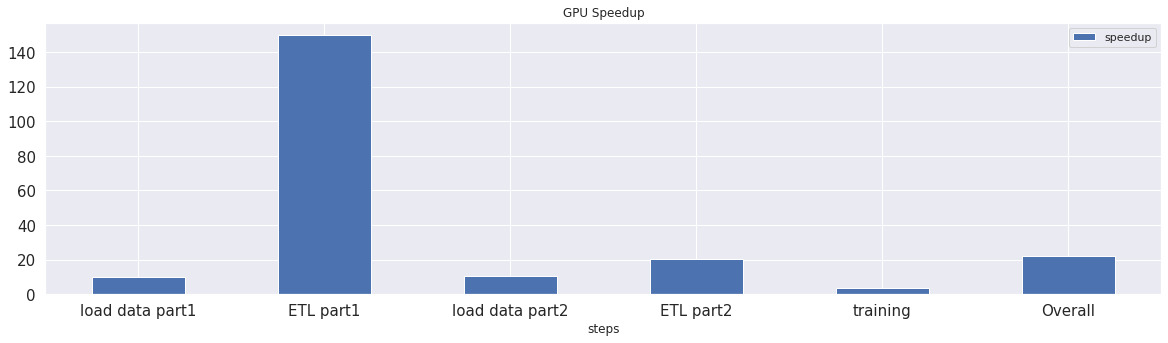

In [43]:
steps = ['load data part1','ETL part1','load data part2','ETL part2','training']
GPU_RUN_TIME['Overall'] = sum([GPU_RUN_TIME[i] for i in steps])
CPU_RUN_TIME['Overall'] = sum([CPU_RUN_TIME[i] for i in steps])
steps.append('Overall')
speedup = [CPU_RUN_TIME[i]/GPU_RUN_TIME[i] for i in steps]
df = pd.DataFrame({'steps':steps, 'speedup':speedup})
df.plot.bar(x='steps', y='speedup', rot=0, figsize=(20,5), fontsize=15, title='GPU Speedup')

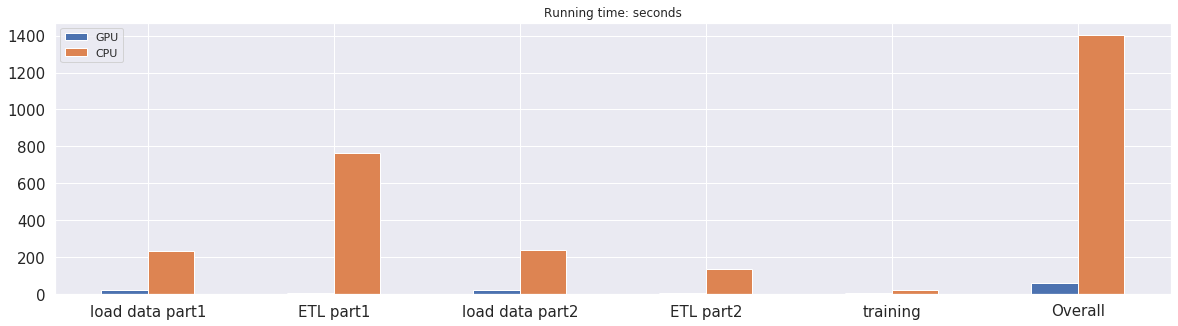

In [44]:
gpu_time = [GPU_RUN_TIME[i] for i in steps]
cpu_time = [CPU_RUN_TIME[i] for i in steps]
df = pd.DataFrame({'GPU': gpu_time,'CPU': cpu_time}, index=steps)
df.plot.bar(rot=0,figsize=(20,5), fontsize=15, title='Running time: seconds')

**The rapids solution achieves up to 140x speedup for ETL and 25x end-to-end speedup over the CPU solution with comparable accuracy.**